#TensorFlow - Advanced Computer Vision Module 1 Exercise

This notebook is the solution to the exercise of Module 1.

**Question**

Build a model that predicts the bounding boxes in [Caltech Birds - 2010](http://www.vision.caltech.edu/visipedia/CUB-200.html) dataset. You must treat it as a regression problem by performing transfer learning on any of the pre-trained models available in Keras.


## Imports

In [ ]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import cv2

print("Tensorflow version " + tf.__version__)

TensorFlow 2.x selected.
Tensorflow version 2.1.0-rc1


#Visualization Utilities

These functions are used to draw bounding boxes around the birds in images.

In [ ]:
#@title Plot Utilities for Bounding Boxes [RUN ME]

im_width = 224
im_height = 224

def draw_bounding_boxes_on_image_array(image,
                                       boxes,
                                       color=[],
                                       thickness=5):
  """Draws bounding boxes on image (numpy array).
  Args:
    image: a numpy array object.
    boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
           The coordinates are in normalized format between [0, 1].
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list_list: a list of strings for each bounding box.
  Raises:
    ValueError: if boxes is not a [N, 4] array
  """

  draw_bounding_boxes_on_image(image, boxes, color, thickness)
  
  return image
  

def draw_bounding_boxes_on_image(image,
                                 boxes,
                                 color=[],
                                 thickness=5):
  """Draws bounding boxes on image.
  Args:
    image: a PIL.Image object.
    boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
           The coordinates are in normalized format between [0, 1].
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
                           
  Raises:
    ValueError: if boxes is not a [N, 4] array
  """
  boxes_shape = boxes.shape
  if not boxes_shape:
    return
  if len(boxes_shape) != 2 or boxes_shape[1] != 4:
    raise ValueError('Input must be of size [N, 4]')
  for i in range(boxes_shape[0]):
    draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                               boxes[i, 2], color[i], thickness)
        
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color=(255, 0, 0),
                               thickness=5):
  """Adds a bounding box to an image.
  Bounding box coordinates can be specified in either absolute (pixel) or
  normalized coordinates by setting the use_normalized_coordinates argument.
  Args:
    image: a PIL.Image object.
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
  """
  im_width = image.shape[1]
  im_height = image.shape[0]
  cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)
  


These utilities are used to visualize the data and predictions.

In [ ]:
#@title Visualization Utilities [RUN ME]
"""
This cell contains helper functions used for visualization
and downloads only. You can skip reading it. There is very
little useful Keras/Tensorflow code here.
"""

# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")



# utility to display a row of digits with their predictions
def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):

  n = len(images)

  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])
  
  for i in range(n):
    ax = fig.add_subplot(1, 10, i+1)
    bboxes_to_plot = []
    if (len(pred_bboxes) > i):
      bbox = pred_bboxes[i]
      bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
      bboxes_to_plot.append(bbox)
    
    if (len(bboxes) > i):
      bbox = bboxes[i]
      if bboxes_normalized == True:
        bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
      bboxes_to_plot.append(bbox)

    img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), color=[(255,0,0), (0, 255, 0)])
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img_to_draw)

    if len(iou) > i :
      color = "black"
      if (iou[i][0] < iou_threshold):
        color = "red"
      ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)


# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [ ]:
BATCH_SIZE = 64

##Loading and Preprocessing the Dataset

###Utility and Preprocessing Functions

In [ ]:

'''
Resizes image to (224, 224), normalizes image and translates and normalizes bounding boxes.
'''
def read_image_tfds(image, bbox):
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)

    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    image = tf.image.resize(image, (224, 224,))

    image = image/127.5
    image -= 1

    return image, [bbox[0] / factor_x , bbox[1] / factor_y, bbox[2] / factor_x , bbox[3] / factor_y]

'''
Helper function to read resized images, bounding boxes and their original shapes.
Resizes image to (224, 224), normalizes image and translates and normalizes bounding boxes.
'''
def read_image_with_shape(image, bbox):
    original_image = image
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)
    
    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    image = tf.image.resize(image, (224, 224,))

    image = image/127.5
    image -= 1

    return original_image, image, [bbox[0] / factor_x , bbox[1] / factor_y, bbox[2] / factor_x , bbox[3] / factor_y]

'''
Reads image and denormalized bounding boxes
'''
def read_image_tfds_with_original_bbox(data):
    image = data["image"]
    bbox = data["bbox"]

    shape = tf.shape(image)

    return image, [bbox[1] * tf.cast(shape[1], tf.float32) , bbox[0] * tf.cast(shape[0], tf.float32), bbox[3] * tf.cast(shape[1], tf.float32), bbox[2] * tf.cast(shape[0], tf.float32)] #[bbox[0] * factor_x , (bbox[1] * factor_y), (bbox[2] * factor_x), (bbox[3] * factor_y)]

  
'''
Convert dataset to numpy arrays of images and boxes.
'''
def dataset_to_numpy_util(dataset, batch_size=0, N=0):

  # eager execution: loop through datasets normally
  take_dataset = dataset.shuffle(1024)

  if batch_size > 0:
    take_dataset = take_dataset.batch(batch_size)
  
  if N > 0:
    take_dataset = take_dataset.take(N)
  
  if tf.executing_eagerly():
    ds_images, ds_bboxes = [], []
    for images, bboxes in take_dataset:
      ds_images.append(images.numpy())
      ds_bboxes.append(bboxes.numpy())
        
  return (np.array(ds_images), np.array(ds_bboxes))

'''
Convert dataset to numpy arrays of original images, resized and normalized images and bounding boxes.
This is used for plotting the original images with true and predicted bounding boxes.
'''
def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0):

  normalized_dataset = dataset.map(read_image_with_shape)
  if batch_size > 0:
    normalized_dataset = normalized_dataset.batch(batch_size)
  
  if N > 0:
    normalized_dataset = normalized_dataset.take(N)

  
  if tf.executing_eagerly():
    ds_original_images, ds_images, ds_bboxes = [], [], []
    for original_images, images, bboxes in normalized_dataset:
      ds_images.append(images.numpy())
      ds_bboxes.append(bboxes.numpy())
      ds_original_images.append(original_images.numpy())

  return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)#, np.array(ds_normalized_images), np.array(ds_normalized_bboxes)

###Loading Dataset

In [ ]:
'''
Loads and maps the training split of the dataset. It used map function to reverse the normalization done on the bounding boxes in the dataset.
This will generate the dataset prepared for visualization
''' 
def get_visualization_training_dataset():      
    dataset, info = tfds.load("caltech_birds2010", split="train", with_info=True)
    print(info)
    visualization_training_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    return visualization_training_dataset
    

'''
Loads and maps the validation split of the dataset. It used map function to reverse the normalization done on the bounding boxes in the dataset.
This will generate the dataset prepared for visualization
''' 
def get_visualization_validation_dataset():
    dataset = tfds.load("caltech_birds2010", split="test", try_gcs=True)
    visualization_validation_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    return visualization_validation_dataset

'''
Loads and maps the training split of the dataset using the map function for resizing, image normalization and bounding box translation.
'''  
def get_training_dataset(dataset):
  dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
  dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
  dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(-1) 
  return dataset

'''
Loads and maps the validation split of the dataset using the map function for resizing, image normalization and bounding box translation.
'''  
def get_validation_dataset(dataset):
  dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.repeat()
  return dataset
  

# instantiate the datasets
visualization_training_dataset = get_visualization_training_dataset()
visualization_validation_dataset = get_visualization_validation_dataset()

training_dataset = get_training_dataset(visualization_training_dataset)
validation_dataset = get_validation_dataset(visualization_validation_dataset)

tfds.core.DatasetInfo(
    name='caltech_birds2010',
    version=0.1.0,
    description='Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
of 200 bird species (mostly North American). The total number of 
categories of birds is 200 and there are 6033 images in the 2010 
dataset and 11,788 images in the 2011 dataset.
Annotations include bounding boxes, segmentation labels.
',
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=200),
        'label_name': Text(shape=(), dtype=tf.string),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
    }),
    total_num_examples=6033,
    splits={
        'test': 3033,
        'train': 3000,
    },
    supervised_keys=('im

### Visualize Data
We take a random sample of images from training and validation set and visualize them by plotting the corresponding bounding boxes. We use the visualization datasets we prepared earlier for this purpose.

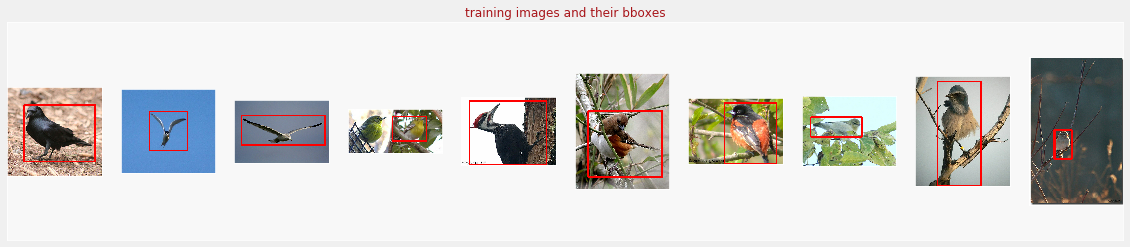

In [ ]:

(visualization_training_images, visualization_training_bboxes) = dataset_to_numpy_util(visualization_training_dataset, N=10)
display_digits_with_boxes(np.array(visualization_training_images), np.array([]), np.array(visualization_training_bboxes), np.array([]), "training images and their bboxes")


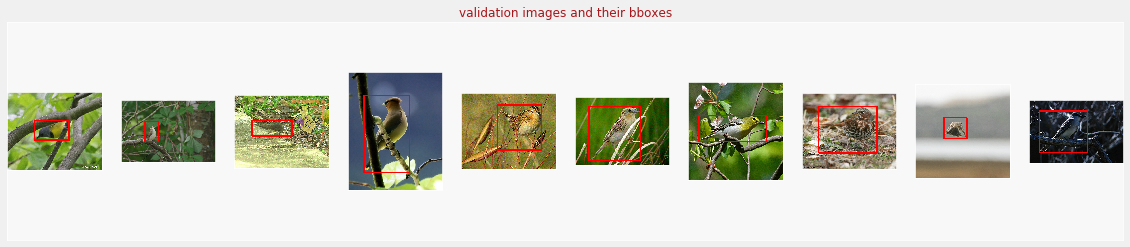

In [ ]:
(visualization_validation_images, visualization_validation_bboxes)= dataset_to_numpy_util(visualization_validation_dataset, N=10)
display_digits_with_boxes(np.array(visualization_validation_images), np.array([]), np.array(visualization_validation_bboxes), np.array([]), "validation images and their bboxes")


##Define the Network

Bounding box prediction is treated as a regression problem.

We will be performing transfer learning on **MobileNet V2** available in Keras pretrained models with **imagenet weights** as starting point.
We have opted to retrain all layers of **MobileNet V2** along with the final classification layers.

Note that we extensively use Keras functional API for this example.

In [ ]:
'''
Feature Extraction is performed by MobileNetV2 pretrained on imagenet weights. Input size is 224 x 224.
'''
def feature_extractor(inputs):
    resnet_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
    
    feature_extractor = resnet_model(inputs)

    return feature_extractor


'''
Defines final dense layers.
'''
def dense_layers(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    return x

'''
This function defines the regression output for bounding box prediction. Note that we have four units in output layer corresponding to (xmin, ymin, xmax, ymax).
'''
def bounding_box_regression(inputs):
    bounding_box_regression_output = tf.keras.layers.Dense(units = '4', name = 'bounding_box')(inputs)
    return bounding_box_regression_output

'''
Connects the feature extraction, fully connected layers and regression layer to build the final model.
'''
def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    dense_output = dense_layers(feature_cnn)

    bounding_box_output = bounding_box_regression(dense_output)

    model = tf.keras.Model(inputs = inputs, outputs =bounding_box_output)

    return model
  

'''
Defines the final model and compiles it. We opt to use Stochastic Gradient Descent as the optimizer with momentum of 0.9 and mse as the loss function.
'''
def define_and_compile_model():
  inputs = tf.keras.layers.Input(shape=(224, 224, 3,))
  model = final_model(inputs)
  
  model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9), 
              loss ='mse')
  return model

    
model = define_and_compile_model()

# print model layers
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
bounding_box (Dense)         (None, 4)                 2052



```
# This is formatted as code
```

## Train the model

In [ ]:
EPOCHS = 80
steps_per_epoch = 3000//BATCH_SIZE  # 3000 items in this dataset
validation_steps = 3033//BATCH_SIZE

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)



Train for 46 steps, validate for 47 steps
Epoch 1/80
46/46 [==============================] - 44s 961ms/step - loss: 0.0893 - val_loss: 0.3876
Epoch 2/80
46/46 [==============================] - 38s 828ms/step - loss: 0.0180 - val_loss: 0.2910
Epoch 3/80
46/46 [==============================] - 38s 833ms/step - loss: 0.0125 - val_loss: 0.2238
Epoch 4/80
46/46 [==============================] - 39s 838ms/step - loss: 0.0101 - val_loss: 0.1995
Epoch 5/80
46/46 [==============================] - 39s 842ms/step - loss: 0.0080 - val_loss: 0.1678
Epoch 6/80
46/46 [==============================] - 38s 816ms/step - loss: 0.0069 - val_loss: 0.1492
Epoch 7/80
46/46 [==============================] - 39s 840ms/step - loss: 0.0063 - val_loss: 0.1251
Epoch 8/80
46/46 [==============================] - 39s 843ms/step - loss: 0.0056 - val_loss: 0.1055
Epoch 9/80
46/46 [==============================] - 39s 843ms/step - loss: 0.0049 - val_loss: 0.0953
Epoch 10/80
46/46 [==============================

TypeError: ignored

##Validate the Model

In [ ]:
loss = model.evaluate(validation_dataset, steps=validation_steps)
print("Loss: ", loss)

47/47 [==============================] - 11s 230ms/step - loss: 0.0155
Loss:  0.015521444281206486


###Plot Loss Function

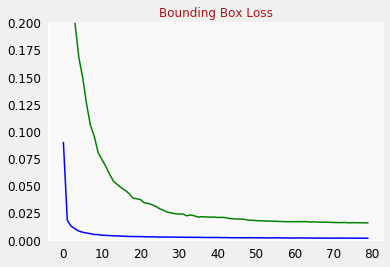

In [ ]:
plot_metrics("loss", "Bounding Box Loss", ylim=0.2)


###Intersection Over Union

In [ ]:
'''
Calulcates and returns list of iou scores for all images in the test set
'''
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(xmin_pred, xmin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred + 1) * (ymax_pred - ymin_pred + 1)
    true_box_area = (xmax_true - xmin_true + 1) * (ymax_true - ymin_true + 1)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap) + 1,0)  * np.maximum((ymax_overlap - ymin_overlap) + 1, 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    #Updates iou score
    iou = overlap_area / union_area

    return iou



In [ ]:
#Makes predictions
original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(visualization_validation_dataset, N=500)
predicted_bboxes = model.predict(normalized_images, batch_size=32)


In [ ]:
#Calculates IOU and reports true positives and false positives based on IOU threshold
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.7

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

Number of predictions where iou > threshold(0.7): 334
Number of predictions where iou < threshold(0.7): 166


### Visualize predictions
Plot predicted and ground truth bounding boxes for a random set of images

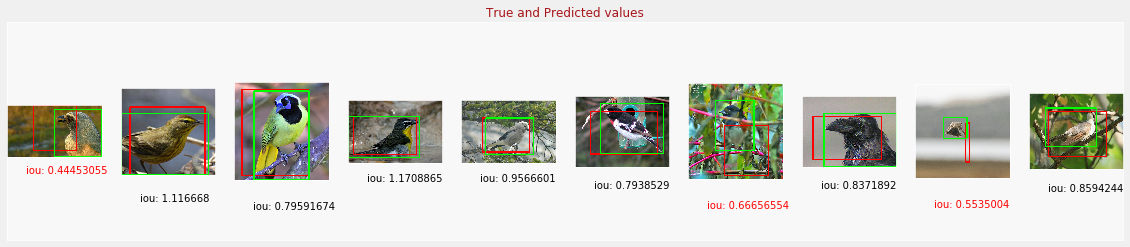

In [ ]:
n = 10
indexes = np.random.choice(len(predicted_bboxes), size=n)

iou_to_draw = iou[indexes]
norm_to_draw = original_images[indexes]
display_digits_with_boxes(original_images[indexes], predicted_bboxes[indexes], normalized_bboxes[indexes], iou[indexes], "True and Predicted values", bboxes_normalized=True)